In [14]:
import sys
sys.path.append('../../../vysxd')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from vysxd_define import *
from vysxd_analysis import *

%matplotlib inline

In [67]:
# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3/MS/DENSITY/electrons/charge/')
# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1_sin2driver/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.11_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.11_sin2driver/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.05_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.05_sin2driver/MS/DENSITY/electrons/charge/')

e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('EPW-alves/MS/FLD/e1/')
edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('EPW-alves/MS/DENSITY/electrons/charge/')
p1x1 = vysxd_get_data('EPW-alves/MS/PHA/p1x1/electrons/p1x1-electrons-000025.h5')

In [104]:
np.shape(p1x1.DATA)
print(len(p1x1.Y))
print(len(p1x1.X))
phasearray = p1x1.DATA
phasearray[127,95]

v_p = p1x1.Y
x_p = p1x1.X

#n_v = np.linspace(0, len(v_p)-1,len(v_p))
#n_v = n_v.astype(int)
#n_v = n_v.tolist()
#print(n_v)

#def p1x1(t):
#    p1x1_files = np.sort(os.listdir('EPW-alves/MS/PHA/p1x1/electrons/'))
#    if not (os.path.isdir('figures-xv-density')):
#        os.makedirs('figures-xv-density')
#    for i in range(len(p1x1_files)):
#        p1x1 = vysxd_get_data('EPW-alves/MS/PHA/p1x1/electrons/' + p1x1_files[i])

def position_averaged_f_v(array):
    n_v = np.linspace(0, len(v_p)-1,len(v_p))
    n_v = n_v.astype(int)
    n_v = n_v.tolist()
    n_x = np.linspace(0, len(x_p)-1,len(x_p))
    n_x = n_x.astype(int)
    n_x = n_x.tolist()
    PAV = []
    for i in n_v:
        integral = np.trapz(array[i,n_x], x_p)
        PAV.append(integral)
    return PAV

v_input = v_p.tolist()
v_ave = v_input[3:-3]

def coarse_grained_in_v(array):
    v_input = v_p.tolist()
    v_ave = v_input[3:-3]
    CGF = np.zeros([128,96])
    CGF += array
    for i in range(0,len(v_ave)):
        for j in range(0,len(x_p)):
            coarse_grain = (1/7)*(0.3*array[i,j]+array[i+1,j]+1.4*array[i+2,j]+1.6*array[i+3,j]+1.4*array[i+4,j]+array[i+5,j]+0.3*array[i+6,j])
            CGF[i+3,j] = coarse_grain
    return CGF

def coarse_grained_in_x(array):
    x_input = x_p.tolist()
    x_ave = x_input[3:-3]
    CGF = np.zeros([128,96])
    CGF += array
    for i in range(0,len(x_ave)):
        for j in range(0,len(v_p)):
            coarse_grain = (1/7)*(0.3*array[j,i]+array[j,i+1]+1.4*array[j,i+2]+1.6*array[j,i+3]+1.4*array[j,i+4]+array[j,i+5]+0.3*array[j,i+6])
            CGF[j,i+3] = coarse_grain
    return CGF

def gradv(array):
    GVA = np.zeros([128,96])
    for i in range(0,len(x_p)):
        gradv = np.gradient(array[:,i])
        GVA[:,i] = gradv
    return GVA

def gradx(array):
    GXA = np.zeros([128,96])
    for i in range(0,len(v_p)):
        gradx = np.gradient(array[i,:])
        GXA[i,:] = gradx
    return GXA

def dWdt(v_p,x_p,t_index,gv,gx,e1_D_xt,q_m=-1):
    n_v = np.linspace(0, len(v_p)-1,len(v_p))
    n_v = n_v.astype(int)
    n_v = n_v.tolist()
    n_x = np.linspace(0, len(x_p)-1,len(x_p))
    n_x = n_x.astype(int)
    n_x = n_x.tolist()
    PAV = np.zeros([128,96])
    for i in n_v:
        for j in n_x:
            vsquared = (v_p[i])**2
            vcubed = (v_p[i])**3
            element = -(q_m*vsquared*e1_D_xt[t_index,n_x[j]]*gv[i,n_x[j]])-(vcubed*gx[i,n_x[j]])
            PAV[i,j] = element 
    return PAV

def dWdt_ave(v_p,x_p,t_index,gv,gx,e1_D_xt,q_m=-1):
    n_v = np.linspace(0, len(v_p)-1,len(v_p))
    n_v = n_v.astype(int)
    n_v = n_v.tolist()
    n_x = np.linspace(0, len(x_p)-1,len(x_p))
    n_x = n_x.astype(int)
    n_x = n_x.tolist()
    PAV = []
    for i in n_v:
        vsquared = (v_p[i])**2
        vcubed = (v_p[i])**3
        integral = np.trapz(-(q_m*vsquared*e1_D_xt[t_index,n_x[1:-1]]*gv[i,n_x[1:-1]])-(vcubed*gx[i,n_x[1:-1]]), x_p[1:-1])
        PAV.append(integral)
    return PAV
#q/m = rqm in input file which should be -1 for electrons
#input v_p for v_p, x_p for x_p, the time index for T and e1_D_xt for el.


128
96


(100, 96)

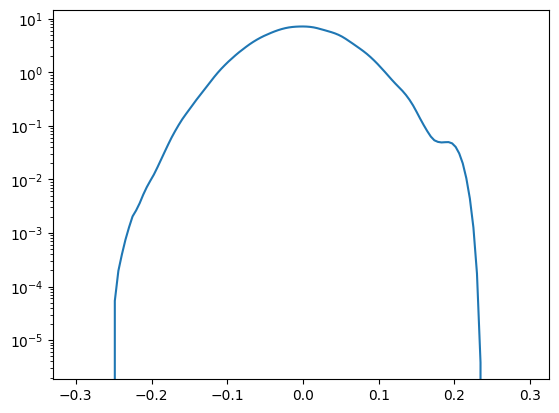

In [69]:
P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)
gradP = gradv(P)
#v_input = v_p.tolist()
#v_ave = v_input[3:-3]
#print(P)
#plt.plot(v_p,position_averaged_f_v(phasearray))
#plt.plot(v_p,phasearray[:,80])
#plt.plot(v_p,np.gradient(phasearray[:,80]))
#phasearray[70,:]
#plt.plot(v_p,phasearray[:,80])
#plt.plot(v_p,np.gradient(phasearray[:,80]))
#plt.plot(v_p,P[:,80])
#plt.plot(v_p,gradP[:,80])

plt.semilogy(v_p,abs(P[:,80]))

len(np.gradient(P[:,80]))
np.shape(e1_D_xt)


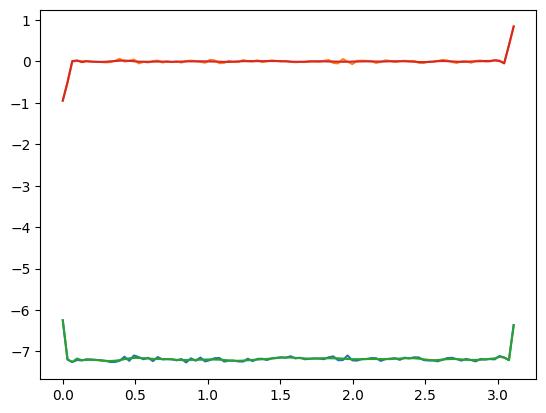

In [118]:

P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)

Billy = gradx(P)
plt.plot(x_p,P[64,:])
plt.plot(x_p,Billy[64,:])

Mandy = gradx(Q)
plt.plot(x_p,Q[64,:])
plt.plot(x_p,Mandy[64,:])

[-3.985578180773571e-09, -1.9310009196892018e-09, 1.1127416505476247e-09, 1.6751880984765075e-09, 1.4281047604212274e-09, 1.4408181287504599e-09, 1.529746413431742e-09, 1.7313862767607592e-09, 7.004213437454938e-10, -3.002257367888943e-08, -1.0444234673886564e-07, -1.6233693676233803e-07, -1.8395880835501023e-07, -1.7373019910379088e-07, -2.0340575154328676e-07, -2.7433766504497094e-07, -4.348084940700103e-07, -6.081409044345981e-07, -7.322380518864146e-07, -5.949491536058951e-07, -3.208106781109768e-07, 1.8947249168314705e-08, 3.8617217221115326e-07, 7.616383629856977e-07, 9.67452485691284e-07, 7.897059682974313e-07, 2.7097416734054777e-07, -1.661404008179309e-07, -3.5990848589532744e-07, -2.7291851238700976e-07, 3.255574274882126e-08, 4.7105960156426033e-07, 6.563850670021103e-07, 6.649538337899384e-07, 5.542026653914474e-07, 4.0802929118411966e-07, 1.6529356304939004e-07, 4.0399749305377725e-08, -1.9194371588406193e-07, -4.408134249116595e-07, -7.348526134264124e-07, -8.303246779494

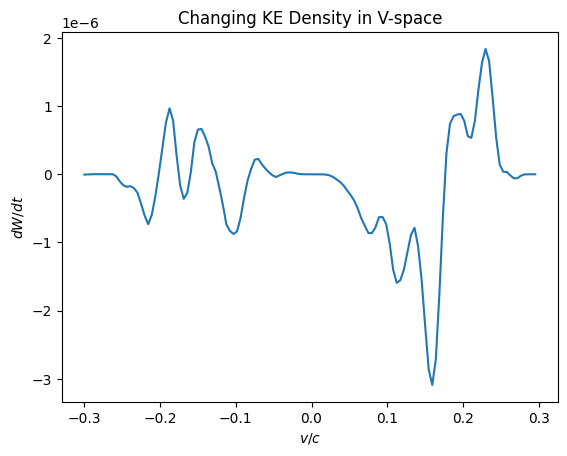

In [116]:
P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)

#print(t)
#print(p1x1.TIME)

KE_change = dWdt_ave(v_p,x_p,25,gradv(Q),gradx(Q),e1_D_xt,-1)

print(KE_change)
print(len(KE_change))
print(len(v_p))
plt.plot(v_p,KE_change, label = 'changing KE density in v-space')
plt.xlabel('$v/c$')
plt.ylabel('$dW/dt$')
plt.title('Changing KE Density in V-space')
plt.legend
plt.savefig('dWdt_in_vspace.png',dpi = 300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


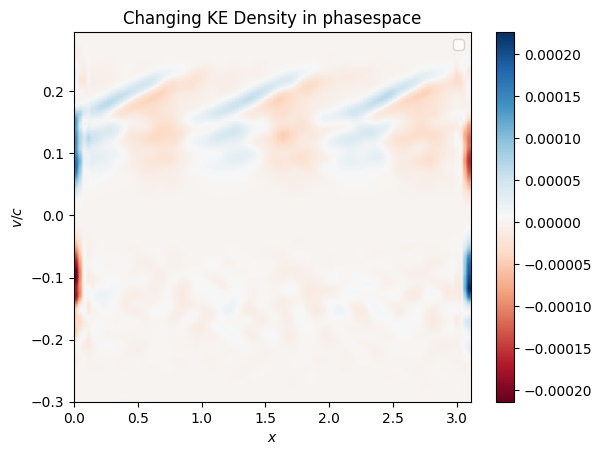

In [117]:
KE_change_xv = dWdt(v_p,x_p,25,gradv(Q),gradx(Q),e1_D_xt,-1)

plt.imshow(KE_change_xv, origin='lower', extent=[x_p[0], x_p[-1], v_p[0], v_p[-1]], aspect='auto', cmap = 'RdBu')
#plt.xlim(0.1,2.9)
plt.xlabel('$x$')
plt.ylabel('$v/c$')
plt.title('Changing KE Density in phasespace')
plt.legend()
plt.colorbar()